In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('./')

file_list = drive.ListFile({'q': "title = 'Neural_Nets-demo'"}).GetList()
ignore = ['.ipynb_checkpoints','__pycache__','core','run_','-ubyte.gz']

subdirs = file_list
subdirs[0]['path'] = local_download_path
subdirs[0]['title'] = ''

def retrieve_folder_files(path_to_folder, folder):
  
    files = drive.ListFile({'q': "'"+folder['id']+"' in parents"}).GetList()
    
    try:
      os.makedirs(os.path.join(path_to_folder,folder['title']))
    except: pass
    
    subdirs = []
    
    for file in files:
      
      #print(file['title'],path_to_folder)
      if all(s not in file['title'] for s in ignore) and all(s not in path_to_folder for s in ignore):
      
        if file['mimeType'][-6:] != 'folder':
          fname = os.path.join(os.path.join(path_to_folder, folder['title']),file['title'])
          print('Getting file:', fname)
          f_ = drive.CreateFile({'id': file['id']})
          f_.GetContentFile(fname)

        else:
          file['path'] = os.path.join(path_to_folder, folder['title'])
          subdirs.append(file)
    
    return(subdirs)

while len(subdirs) > 0:
  
  ssubdirs = []
  
  for folder in subdirs:
    #print(os.path.join(folder['path'], folder['title']))
    ssubdirs += (retrieve_folder_files(folder['path'], folder))
      
  subdirs = ssubdirs

Saving file: ./Conv_MNIST.ipynb
Saving file: ./Basic_MNIST.ipynb
Saving file: ./Basic_MNIST-keasy.ipynb
Saving file: ./visualization_funcs.py
Saving file: ./pytorch_models/Conv_MNIST-p.ipynb
Saving file: ./pytorch_models/Basic_MNIST-p.ipynb
Saving file: ./MNIST_data/sprite_1024.png
Saving file: ./MNIST_data/labels_1024.tsv
Saving file: ./tb_models/Conv_MNIST-tb.ipynb
Saving file: ./tb_models/Basic_MNIST-tb.ipynb
Saving file: ./keras_models/Conv_MNIST-k.ipynb
Saving file: ./keras_models/Basic_MNIST-k.ipynb


# MNIST Handwriten Digits Classifier

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
image_size = 28
num_classes = 10

In [0]:
batch_size = 100
learning_rate = 0.2
dropout_rate = 0.4

epochs = 2
iterations = mnist.train.num_examples//batch_size

In [0]:
tf.reset_default_graph()

In [0]:
X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

# whether we are training or evaluating
# so we can apply dropout or not
is_training = tf.placeholder_with_default(input=False, shape=[], name='is_training')

# reshape the input image into tensorflows required format (N,H,W,C)
X_image = tf.reshape(X_placeholder, [-1,image_size,image_size,1])

In [0]:
# convolutional layer 1
conv1 = tf.layers.conv2d(inputs=X_image,
                         filters=8,
                         kernel_size=[5, 5],
                         activation=tf.nn.relu)

# max pool conv1
pool1 = tf.layers.max_pooling2d(inputs=conv1,
                                pool_size=[2, 2],
                                strides=2)

In [0]:
# convolutional layer 2
conv2 = tf.layers.conv2d(inputs=pool1,
                         filters=16,
                         kernel_size=[5, 5],
                         activation=tf.nn.relu)

# max pool conv2
pool2 = tf.layers.max_pooling2d(inputs=conv2,
                                pool_size=[2, 2],
                                strides=2)

In [0]:
# flatten for fc layers
pool2_flat = tf.reshape(pool2, [-1, 4 * 4 * 16])

# fc layer 1
fc1 = tf.layers.dense(inputs=pool2_flat,
                        units=256,
                        activation=tf.nn.relu)

# apply dropout to fc layer 1
dropout = tf.layers.dropout(inputs=fc1,
                            rate=dropout_rate,
                            training=is_training)

In [0]:
# output layer
Y_prediction = tf.layers.dense(inputs=dropout,
                               units=num_classes)

In [0]:
# define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder,
                                                                 logits=Y_prediction,
                                                                 name='loss'))

# define optimizer and training step
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [0]:
# compute accuracy
correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# create session
sess = tf.InteractiveSession()
# initialize variables
sess.run(tf.global_variables_initializer())

In [15]:
# training

losses = np.array([])

for epoch in range(epochs):

    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    for idx in range(iterations):

        batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)

        _, _loss = sess.run([train_step, loss], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys,
                                is_training : True
                            })

        if (idx+1) % (iterations/5) == 0:

            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                      Y_placeholder : mnist.validation.labels,
                                                     })
            
            print('step', str(idx+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')
            
        losses = np.append(losses, np.mean(_loss))

New epoch 1/2
step 110/550 loss 0.29490182 accuracy 90.04%
step 220/550 loss 0.15191554 accuracy 94.84%
step 330/550 loss 0.12094736 accuracy 96.86%
step 440/550 loss 0.16454723 accuracy 96.86%
step 550/550 loss 0.045350086 accuracy 97.64%
New epoch 2/2
step 110/550 loss 0.07890666 accuracy 97.92%
step 220/550 loss 0.040967382 accuracy 98.16%
step 330/550 loss 0.04550247 accuracy 98.14%
step 440/550 loss 0.07047955 accuracy 98.3%
step 550/550 loss 0.036914412 accuracy 98.18%


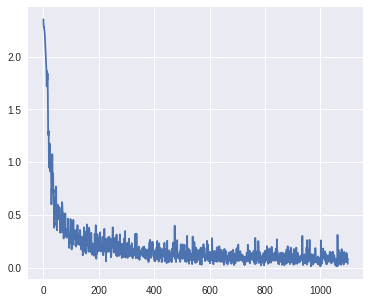

In [16]:
# plot training losses

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(losses)
ax.grid(True)

In [17]:
# get evaluation accuracy
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels
                                         })

print(str(round(100*_accuracy,2))+'%')

98.13%


prediction: 2 answer: 2
0 0.001%
1 0.006%
2 99.993%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.0%
9 0.0%


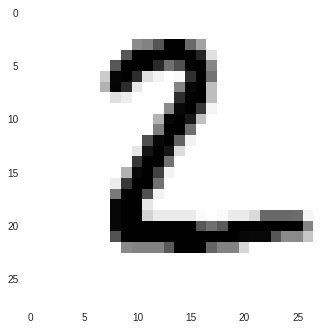

prediction: 6 answer: 6
0 0.056%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.002%
6 99.937%
7 0.0%
8 0.006%
9 0.0%


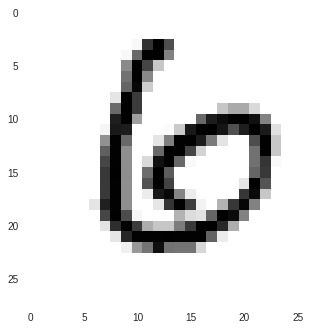

In [18]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x, test_y = mnist.test.images[test_idx], mnist.test.labels[test_idx]

    _prediction = sess.run(Y_prediction, feed_dict={X_placeholder: test_x.reshape(1,-1)})

    print('prediction:', np.argmax(_prediction), 'answer:', np.argmax(test_y))

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(100*np.exp(val)/np.sum(np.exp(_prediction)),3))+'%')

    plt.imshow(test_x.reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()